In [1]:
using DrWatson 

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using PersistenceDiagrams, Pipe, Plots, ProgressMeter, Random, Ripserer, Statistics, StatsBase

In [3]:
function generate_sbm(n, k, p, r)
    f = (x, y) -> r + p * (x == y)
    Z = rand(1:k, n)
    return rdpg.Adjacency(f, Z)
end

generate_sbm (generic function with 1 method)

In [4]:
params = (; p=0.25, r=0.5, clust=4, d=2, order=0, q=Inf, repeats=30)

N = [500, 1000, 2000]
ϵ = [1.0:0.5:5...]
n = length(ϵ);

In [5]:
with_eps    = [zeros(params.repeats, n) for _ in eachindex(N)];
without_eps = [zeros(params.repeats, n) for _ in eachindex(N)];

prog = ProgressMeter.Progress(convert(Int, n * params.repeats * length(N)))

Random.seed!(2022)


for j in eachindex(N)
    
    A = generate_sbm(N[j], params.clust, params.p, params.r)
    X, _, _ = rdpg.spectralEmbed(A, d=params.d, scale=false)
    X_norm = rdpg.scale_embeddings(X)
    DX = rdpg.diagram(X |> rdpg.subsample, dim_max=params.order)
    DX_norm = rdpg.diagram(X_norm |> rdpg.subsample, dim_max=params.order)

    for i in 1:n, k in 1:params.repeats
            
        A1 = rdpg.edgeFlip(A, ϵ=ϵ[i])            
        X1, _ = rdpg.spectralEmbed(A1, d=params.d, scale=false)
        X1_norm = rdpg.scale_embeddings(X1)
        D1_norm = rdpg.diagram(X1_norm |> rdpg.subsample, dim_max=params.order)
        without_eps[j][k, i] = rdpg.bottleneck_distance(DX_norm, D1_norm, order=params.order, p=params.q)

        A2 = (A1 .- rdpg.τ(ϵ[i])^2) ./ rdpg.σ(ϵ[i])^2
        X2, _ = rdpg.spectralEmbed(A2, d=params.d, scale=false)
        D2 = rdpg.diagram(X2 |> rdpg.subsample, dim_max=params.order)
        with_eps[j][k, i] = rdpg.bottleneck_distance(DX, D2, order=params.order, p=params.q)
            
        next!(prog)
    end
end

Progress:  55%|██████████████████████▋                  |  ETA: 0:00:44QH7086 Qhull precision warning: repartition coplanar point p263 from f7 as an outside point above hidden facet f6 dist 3.9e-13 nearest vertices 0.011
QH7086 Qhull precision warning: repartition coplanar point p285 from f7 as an outside point above hidden facet f7 dist 3.6e-13 nearest vertices 0.011
QH7086 Qhull precision warning: repartition coplanar point p119 from f7 as an outside point above hidden facet f7 dist 3.6e-13 nearest vertices 0.011
QH7086 Qhull precision warning: repartition coplanar point p507 from f7 as an outside point above hidden facet f7 dist 4.5e-13 nearest vertices 0.011
QH7086 Qhull precision warning: repartition coplanar point p341 from f7 as an outside point above hidden facet f7 dist 4.1e-13 nearest vertices 0.011
Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:19QH7086 Qhull precision warning: repartition coplanar point p32 from f7 as an outside point above hidden face

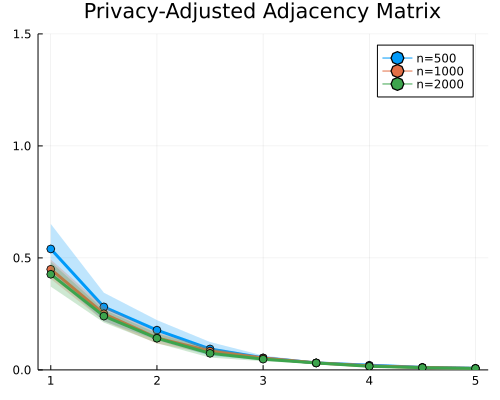

In [6]:
plt1 = plot(title="Privacy-Adjusted Adjacency Matrix")
for k in eachindex(N)
    plot!(plt1, ϵ,
        with_eps[k] |> eachcol .|> median,
        ribbon = with_eps[k] |> eachcol .|> mad,
        marker=:o,
        label="n=$(N[k])",
        lw=3, fa=0.25,
    )
end
plt1 = plot(plt1, ylim=(0, 1.5), size=(500, 400))

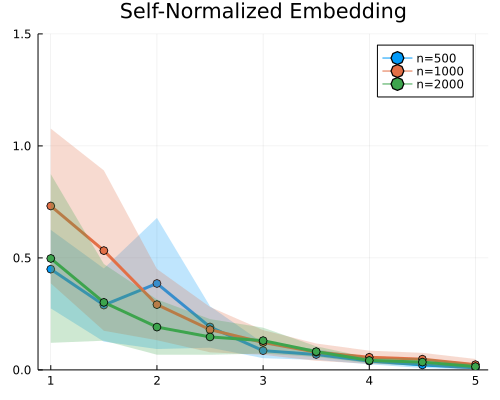

In [7]:
plt2 = plot(title="Self-Normalized Embedding")
for k in eachindex(N)
    plot!(plt2, ϵ,
        without_eps[k] |> eachcol .|> median,
        ribbon = without_eps[k] |> eachcol .|> mad,
        marker=:o,
        label="n=$(N[k])",
        lw=3, fa=0.25,
    )
end
plt2 = plot(plt2, ylim=(0,1.5), size=(500,400))

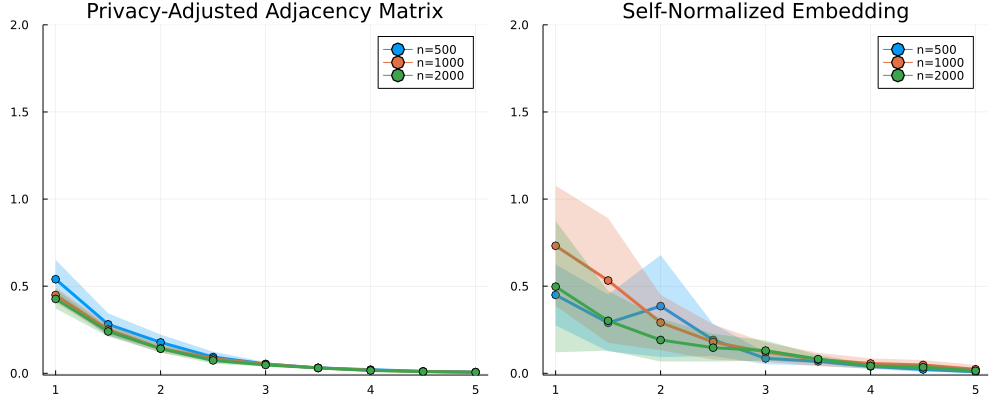

In [8]:
lim = (-0.010, 2)
plot(plot(plt1, ylim=lim), plot(plt2, ylim=lim), size=(1000, 400))

In [9]:
savefig(plt1, plotsdir("comparisons/sim-with-eps.pdf"))

In [10]:
savefig(plt2, plotsdir("comparisons/sim-without-eps.pdf"))

In [17]:
plt1 = plot(title="Privacy-Adjusted Adjacency Matrix")
for k in eachindex(N)
    plot!(plt1, ϵ,
        with_eps[k] |> eachcol .|> median,
        ribbon = with_eps[k] |> eachcol .|> mad,
        marker=:o,
        label="n=$(N[k])",
        lw=2.5, fa=0.25, xticks=ϵ,
    )
end
plt1 = plot(plt1, ylim=(-1e-2, 1.1), lim=(0.9, 5.1), size=(500, 400))
savefig(plt1, plotsdir("comparisons/sim-with-eps.pdf"))

In [18]:
plt2 = plot(title="Self-Normalized Embedding")
for k in eachindex(N)
    plot!(plt2, ϵ,
        without_eps[k] |> eachcol .|> median,
        ribbon = without_eps[k] |> eachcol .|> mad,
        marker=:o,
        label="n=$(N[k])",
        lw=2.5, fa=0.25, xticks=ϵ,
    )
end
plt2 = plot(plt2, ylim=(-1e-2, 1.1), lim=(0.9, 5.1), size=(500, 400))
savefig(plt2, plotsdir("comparisons/sim-without-eps.pdf"))